In [4]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

img_dir = './semi_draw_img/nin'
categories = ['concopy', 'unconcopy']
np_classes = len(categories)

image_w = 64
image_h = 64


pixel = image_h * image_w * 3

X = []
y = []

for idx, conformal in enumerate(categories):
    img_dir_detail = img_dir + "/" + conformal
    files = glob.glob(img_dir_detail+"/*.*")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(conformal, " : ", f)
        except:
            print(conformal, str(i)+" 번째에서 에러 ")
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/drawtest5.npy", xy)

concopy  :  ./semi_draw_img/nin/concopy\com12_0_1233.png
concopy  :  ./semi_draw_img/nin/concopy\com1_0_9377.png
unconcopy  :  ./semi_draw_img/nin/unconcopy\uncom16_0_1233.png
unconcopy  :  ./semi_draw_img/nin/unconcopy\uncom2_0_9377.png


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

X_train, X_test, y_train, y_test = np.load('./numpy_data/drawtest5.npy')

print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(596, 64, 64, 3)
596
[320 276]
[37 30]


In [6]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model_dir = './model'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "/uncon_con_classify.model"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7)


In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)         

In [8]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

Train on 506 samples, validate on 90 samples
Epoch 1/100
506/506 [==============================] - 3s 6ms/step - loss: 0.6734 - accuracy: 0.5949 - val_loss: 0.5719 - val_accuracy: 0.8889

Epoch 00001: val_loss improved from inf to 0.57190, saving model to ./model/uncon_con_classify.model
Epoch 2/100
506/506 [==============================] - 3s 5ms/step - loss: 0.5356 - accuracy: 0.7925 - val_loss: 0.3797 - val_accuracy: 0.9000

Epoch 00002: val_loss improved from 0.57190 to 0.37970, saving model to ./model/uncon_con_classify.model
Epoch 3/100
506/506 [==============================] - 2s 5ms/step - loss: 0.4314 - accuracy: 0.8162 - val_loss: 0.3410 - val_accuracy: 0.8889

Epoch 00003: val_loss improved from 0.37970 to 0.34103, saving model to ./model/uncon_con_classify.model
Epoch 4/100
506/506 [==============================] - 2s 5ms/step - loss: 0.4065 - accuracy: 0.8360 - val_loss: 0.3195 - val_accuracy: 0.8889

Epoch 00004: val_loss improved from 0.34103 to 0.31946, saving model

In [9]:
print("정확도 : %.3f " %(model.evaluate(X_test, y_test)[1]))

67/67 [==============================] - 0s 2ms/step
정확도 : 1.000 


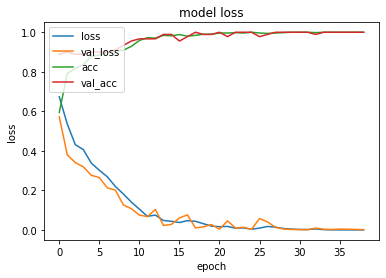

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')

fig = plt.gcf()
plt.show()
fig.savefig('modelloss.png')

In [11]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

import tensorflow as tf

seed = 5
tf.set_random_seed(seed)
np.random.seed(seed)

caltech_dir = './testcon/imgtest'


image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*/*.*")

for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)

X = np.array(X)
X = X.astype(float) / 255

model = load_model('./model/uncon_con_classify.model')
prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

for i in prediction:
    if i >= 0.5: print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는 unconformal 로 추정됩니다.")
    else : print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  이미지는 conformal 으로 추정됩니다.")
    cnt += 1

해당 newtestnewcon.1.PNG  이미지는 conformal 으로 추정됩니다.
해당 newtestnewcon.PNG  이미지는 conformal 으로 추정됩니다.
해당 newtestnewuncon.0.PNG  이미지는 conformal 으로 추정됩니다.
해당 newtestnewuncon.1.PNG  이미지는 unconformal 로 추정됩니다.
해당 newtestnewuncon.2.PNG  이미지는 unconformal 로 추정됩니다.
해당 ttestcom.0.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.1.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.2.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.3.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.4.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.5.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestcom.6.PNG  이미지는 conformal 으로 추정됩니다.
해당 ttestuncom.0.jpg  이미지는 unconformal 로 추정됩니다.
해당 ttestuncom.1.PNG  이미지는 unconformal 로 추정됩니다.
해당 ttestuncom.2.PNG  이미지는 unconformal 로 추정됩니다.
해당 ttestuncom.3.PNG  이미지는 unconformal 로 추정됩니다.
해당 ttestuncom.4.PNG  이미지는 unconformal 로 추정됩니다.
해당 ttestuncom.5.gif  이미지는 unconformal 로 추정됩니다.
